In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

from scipy.stats import spearmanr

from transformers import BertModel, BertTokenizer
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import os
from collections import Counter

1. Load the dataset 

In [12]:
test_df = pd.read_csv(path+ 'test.csv')
test_df = test_df.drop(columns=['data_source'])
deletions = test_df.loc[test_df.protein_sequence.str.len()==220,'seq_id'].values

In [13]:
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

In [14]:
def get_test_mutation(row):
    for i,(a,b) in enumerate(zip(row.protein_sequence,base)):
        if a!=b: break
    row['wildtype'] = base[i]
    row['mutation'] = row.protein_sequence[i]
    row['position'] = i+1
    return row
test_df = test_df.apply(get_test_mutation,axis=1)
test_df.loc[test_df.index.isin(deletions),'mutation'] = '_'
test_df.head()

,seq_id,protein_sequence,pH,wildtype,mutation,position
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,L,E,17
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,L,K,17
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,L,K,17
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,K,C,18
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,K,F,18


In [15]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert")

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
#load training data (will be put in a function later)  
path = os.getcwd()
for i in range(3) :

    path = os.path.dirname(path)

path += '/data/'
train_df = pd.read_csv(path + 'clean_train_data.csv')
train_df = train_df.dropna()
train_df.head()

,protSeq1,protSeq2,operation,position1,position2,change1,change2,pH1,data_source1,tm1,group1,pH2,data_source2,tm2,group2,target
0,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNDFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,D,6.5,10.1038/334406a0,62.9,5,6.5,10.1038/334406a0,56.2,5,-6.7
1,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNEFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,E,6.5,10.1038/334406a0,62.9,5,6.5,10.1038/334406a0,59.0,5,-3.9
2,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNFFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,F,6.5,10.1038/334406a0,62.9,5,6.5,10.1038/334406a0,61.7,5,-1.2
3,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNGFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,G,6.5,10.1038/334406a0,62.9,5,6.5,10.1038/334406a0,58.9,5,-4.0
4,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNLFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,L,6.5,10.1038/334406a0,62.9,5,6.5,10.1038/334406a0,65.6,5,2.7


In [23]:
train_df = train_df.drop(columns=['position2','pH2','data_source1','data_source2','group2'])

In [24]:
train_df = train_df.drop(columns=['operation'])

In [25]:
train_df.groupby('group1').get_group(9)

,protSeq1,protSeq2,position1,change1,change2,pH1,tm1,group1,tm2,target
172,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,94,C,S,7.0,50.1,9,51.1,1.0
173,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,94,C,S,7.0,50.1,9,52.5,2.4
174,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,94,C,V,7.0,50.1,9,52.4,2.3
175,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,94,C,V,7.0,50.1,9,51.1,1.0
176,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,94,C,S,7.0,48.9,9,51.1,2.2
...,...,...,...,...,...,...,...,...,...,...
1253,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,94,V,S,7.0,52.4,9,52.5,0.1
1254,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,94,V,C,7.0,51.1,9,50.1,-1.0
1255,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,94,V,C,7.0,51.1,9,48.9,-2.2
1256,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,94,V,S,7.0,51.1,9,51.1,0.0


In [21]:
from tqdm import tqdm


embeddings_list_1 = []
for i in tqdm(range(0, len(train_df))):
    sequence_Example = ' '.join([*train_df['protSeq1'].iloc[i]])
    encoded_input = tokenizer(sequence_Example, add_special_tokens=True, padding=True, is_split_into_words=True, return_tensors="pt")
    output = model(**encoded_input)
    output = output[1].detach().cpu().numpy()[0]
    embeddings_list_1.append(output)

embeddings_list_2 = []
for i in tqdm(range(0, len(train_df))):
    sequence_Example = ' '.join([*train_df['protSeq2'].iloc[i]])
    encoded_input = tokenizer(sequence_Example, add_special_tokens=True, padding=True, is_split_into_words=True, return_tensors="pt")
    output = model(**encoded_input)
    output = output[1].detach().cpu().numpy()[0]
    embeddings_list_2.append(output)

In [278]:
with open('prot_bert.npy', 'rb') as f:
    emb1 = np.load(f)
    emb2 = np.load(f)

In [279]:
emb_2_channels = np.stack((emb1,emb2),axis=1)

In [280]:
emb_2_channels.shape

(2296, 2, 1024)

In [281]:
emb_conc = np.concatenate((emb1,emb2),axis=1)

In [282]:
emb_conc.shape

(2296, 2048)

with open('prot_bert.npy', 'wb') as f:
    np.save(f, emb1)
    np.save(f, emb2)

In [283]:
new_df['emb_conc'] = emb_conc.tolist()

In [284]:
new_df

,target,embeddings1,embeddings2,diff,pH,2_channels,target_norm,emb_conc,emb_conc_100
0,-6.7,"[-0.2543777525424957, 0.26851749420166016, -0....","[-0.25311586260795593, 0.2672012448310852, -0....","[-0.001261889934539795, 0.0013162493705749512,...",-0.1875,"[[-0.2543777525424957, 0.26851749420166016, -0...",-0.727216,"[-0.2543777525424957, 0.26851749420166016, -0....","[-25.437774658203125, 26.851749420166016, -24...."
1,-3.9,"[-0.2543777525424957, 0.26851749420166016, -0....","[-0.2523089051246643, 0.2663576900959015, -0.2...","[-0.002068847417831421, 0.002159804105758667, ...",-0.1875,"[[-0.2543777525424957, 0.26851749420166016, -0...",-0.423305,"[-0.2543777525424957, 0.26851749420166016, -0....","[-25.437774658203125, 26.851749420166016, -24...."
2,-1.2,"[-0.2543777525424957, 0.26851749420166016, -0....","[-0.2531052827835083, 0.2671898603439331, -0.2...","[-0.0012724697589874268, 0.0013276338577270508...",-0.1875,"[[-0.2543777525424957, 0.26851749420166016, -0...",-0.130248,"[-0.2543777525424957, 0.26851749420166016, -0....","[-25.437774658203125, 26.851749420166016, -24...."
3,-4.0,"[-0.2543777525424957, 0.26851749420166016, -0....","[-0.25340425968170166, 0.26750609278678894, -0...","[-0.0009734928607940674, 0.0010114014148712158...",-0.1875,"[[-0.2543777525424957, 0.26851749420166016, -0...",-0.434159,"[-0.2543777525424957, 0.26851749420166016, -0....","[-25.437774658203125, 26.851749420166016, -24...."
4,2.7,"[-0.2543777525424957, 0.26851749420166016, -0....","[-0.2538793981075287, 0.2679957449436188, -0.2...","[-0.000498354434967041, 0.0005217492580413818,...",-0.1875,"[[-0.2543777525424957, 0.26851749420166016, -0...",0.293057,"[-0.2543777525424957, 0.26851749420166016, -0....","[-25.437774658203125, 26.851749420166016, -24...."
...,...,...,...,...,...,...,...,...,...
2291,12.6,"[-0.2874396741390228, 0.3030060827732086, -0.2...","[-0.28740358352661133, 0.30296844244003296, -0...","[-3.6090612411499023e-05, 3.764033317565918e-0...",0.0000,"[[-0.2874396741390228, 0.3030060827732086, -0....",1.367600,"[-0.2874396741390228, 0.3030060827732086, -0.2...","[-28.743967056274414, 30.300607681274414, -27...."
2292,25.9,"[-0.2874396741390228, 0.3030060827732086, -0.2...","[-0.28744038939476013, 0.3030068576335907, -0....","[7.152557373046875e-07, -7.748603820800781e-07...",0.0000,"[[-0.2874396741390228, 0.3030060827732086, -0....",2.811178,"[-0.2874396741390228, 0.3030060827732086, -0.2...","[-28.743967056274414, 30.300607681274414, -27...."
2293,-7.6,"[-0.28744038939476013, 0.3030068576335907, -0....","[-0.2874530553817749, 0.30302003026008606, -0....","[1.2665987014770508e-05, -1.3172626495361328e-...",0.0000,"[[-0.28744038939476013, 0.3030068576335907, -0...",-0.824902,"[-0.28744038939476013, 0.3030068576335907, -0....","[-28.74403953552246, 30.30068588256836, -27.39..."
2294,-13.3,"[-0.28744038939476013, 0.3030068576335907, -0....","[-0.28740358352661133, 0.30296844244003296, -0...","[-3.680586814880371e-05, 3.841519355773926e-05...",0.0000,"[[-0.28744038939476013, 0.3030068576335907, -0...",-1.443578,"[-0.28744038939476013, 0.3030068576335907, -0....","[-28.74403953552246, 30.30068588256836, -27.39..."


In [285]:
new_df['emb_conc_100']  = (emb_conc *100).tolist()

In [286]:
new_df = train_df['target'].to_frame()

In [287]:
new_df['2_channels'] = emb_2_channels.tolist()

In [288]:

#column to datafram
new_df['embeddings1'] = emb1.tolist()

# add difference of embeddings to dataframe
new_df['embeddings2'] = emb2.tolist()

In [289]:
new_df['diff'] = new_df.apply(lambda row : np.array(row['embeddings1'])- np.array(row['embeddings2']),axis=1)

In [290]:
new_df['pH'] = train_df['pH1']

In [291]:
new_df['diff*10000']  = new_df['diff']* 10000

In [292]:
new_df['pH'] = (new_df['pH'] - 8) / max(new_df['pH'])

In [294]:
new_df['length'] = train_df['length']

new_df.to_csv('prot_bert_embeddings.csv')

In [295]:
new_df

,target,2_channels,embeddings1,embeddings2,diff,pH,diff*10000,length
0,-6.7,"[[-0.2543777525424957, 0.26851749420166016, -0...","[-0.2543777525424957, 0.26851749420166016, -0....","[-0.25311586260795593, 0.2672012448310852, -0....","[-0.001261889934539795, 0.0013162493705749512,...",-0.1875,"[-12.61889934539795, 13.162493705749512, -12.1...",164
1,-3.9,"[[-0.2543777525424957, 0.26851749420166016, -0...","[-0.2543777525424957, 0.26851749420166016, -0....","[-0.2523089051246643, 0.2663576900959015, -0.2...","[-0.002068847417831421, 0.002159804105758667, ...",-0.1875,"[-20.68847417831421, 21.59804105758667, -19.86...",164
2,-1.2,"[[-0.2543777525424957, 0.26851749420166016, -0...","[-0.2543777525424957, 0.26851749420166016, -0....","[-0.2531052827835083, 0.2671898603439331, -0.2...","[-0.0012724697589874268, 0.0013276338577270508...",-0.1875,"[-12.724697589874268, 13.276338577270508, -12....",164
3,-4.0,"[[-0.2543777525424957, 0.26851749420166016, -0...","[-0.2543777525424957, 0.26851749420166016, -0....","[-0.25340425968170166, 0.26750609278678894, -0...","[-0.0009734928607940674, 0.0010114014148712158...",-0.1875,"[-9.734928607940674, 10.114014148712158, -9.38...",164
4,2.7,"[[-0.2543777525424957, 0.26851749420166016, -0...","[-0.2543777525424957, 0.26851749420166016, -0....","[-0.2538793981075287, 0.2679957449436188, -0.2...","[-0.000498354434967041, 0.0005217492580413818,...",-0.1875,"[-4.98354434967041, 5.217492580413818, -4.7753...",164
...,...,...,...,...,...,...,...,...
2291,12.6,"[[-0.2874396741390228, 0.3030060827732086, -0....","[-0.2874396741390228, 0.3030060827732086, -0.2...","[-0.28740358352661133, 0.30296844244003296, -0...","[-3.6090612411499023e-05, 3.764033317565918e-0...",0.0000,"[-0.36090612411499023, 0.3764033317565918, -0....",537
2292,25.9,"[[-0.2874396741390228, 0.3030060827732086, -0....","[-0.2874396741390228, 0.3030060827732086, -0.2...","[-0.28744038939476013, 0.3030068576335907, -0....","[7.152557373046875e-07, -7.748603820800781e-07...",0.0000,"[0.007152557373046875, -0.007748603820800781, ...",537
2293,-7.6,"[[-0.28744038939476013, 0.3030068576335907, -0...","[-0.28744038939476013, 0.3030068576335907, -0....","[-0.2874530553817749, 0.30302003026008606, -0....","[1.2665987014770508e-05, -1.3172626495361328e-...",0.0000,"[0.12665987014770508, -0.13172626495361328, 0....",537
2294,-13.3,"[[-0.28744038939476013, 0.3030068576335907, -0...","[-0.28744038939476013, 0.3030068576335907, -0....","[-0.28740358352661133, 0.30296844244003296, -0...","[-3.680586814880371e-05, 3.841519355773926e-05...",0.0000,"[-0.3680586814880371, 0.3841519355773926, -0.3...",537


In [156]:
new_df['target_norm'] = ( new_df['target'] - new_df['target'].mean() ) / new_df['target'].std()

In [342]:
class Emb2torch(Dataset):
 
    def __init__(self,df,train=True):
    
        # the Amino acid sequences as an int array
        sequence= df['diff']
        # numerical : pH and length
        numerical = df[['pH','length']].values
        print(numerical.shape)
        # y : the target (tm)
        if train == True : 
            y=df['target'].values
        else : 
            y = np.zeros(len(sequence))
            
            
        self.y=torch.tensor(y,dtype=torch.float32)
        #creta tensors from the numpy arrays
        self.x_sequence=torch.tensor(sequence)
       
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x_sequence[idx],self.y[idx] , self.num[idx]

In [343]:
train_df = new_df.sample(frac=0.8,random_state=24)
val_df = new_df.drop(train_df.index)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


In [344]:
# hyperparameters
batch_size = 64
learning_rate = 0.001 # Suggested for Adam
num_epochs = 100


In [345]:
# create pytorch dataframes
train_d = Emb2torch(train_df)
val_d = Emb2torch(val_df)


# create pytorch dataloaders
train_dl = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_d, batch_size=batch_size, shuffle=True)

(1837, 2)
(459, 2)


class EnzymesDataset(Dataset):
 
    def __init__(self,df,train=True):
    
        # the Amino acid sequences as an int array
        sequence= df['encoded_sequence']
        # numerical : pH and length
        numerical = df[['pH','length']].values

        # y : the target (tm)
        if train == True : 
            y=df['tm'].values
        else : 
            y = np.zeros(len(sequence))
        self.y=torch.tensor(y,dtype=torch.float32)
        #creta tensors from the numpy arrays
        self.x_sequence=torch.tensor(sequence)
       
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x_sequence[idx],self.y[idx] , self.num[idx]

## Create 1d conv net

1. get DataLoader from train_dl

class EnzymesDataset(Dataset):
 
    def __init__(self,df,train=True):
    
        # the Amino acid sequences as an int array
        sequence= df['encoded_sequence']
        # numerical : pH and length
        numerical = df[['pH','length']].values

        # y : the target (tm)
        if train == True : 
            y=df['tm'].values
        else : 
            y = np.zeros(len(sequence))
        self.y=torch.tensor(y,dtype=torch.float32)
        #creta tensors from the numpy arrays
        self.x_sequence=torch.tensor(sequence)
       
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x_sequence[idx],self.y[idx] , self.num[idx]


a faire : apres avoir fait one hot encoding, trouver comment mettre l'info de plusieurs channels dans le dataframe, sans qu'il mette d'erreur sur la taille. 
Voir comment mettre un tableau = 1 aa puis la longueur de la ligne = longueur totale (juste transposer ?)


class MyLoss(torch.nn.Module):
    def __init__(self, batch_size, classes):
        super(MyLoss, self).__init__()
        # define some attributes
        self.y_true_one_hot = torch.FloatTensor(batch_size, classes, length)

    def forward(self, y_pred, y_true):
        with torch.no_grad():
            self.y_true_one_hot.zero_().scatter_(1, y_true, 1) # permet one hot encoding
        # do some operations
        return loss


Or use cross entropy loss ?

# create pytorch dataframes
train_d = EnzymesDataset(df)
val_d = EnzymesDataset(test_df,train=False)


# create pytorch dataloaders
train_dl = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_d, batch_size=batch_size, shuffle=True)

In [376]:
class Conv1D_OneChannel(nn.Module):

    def __init__(self):
        super().__init__()
       
        self.prot_seq_one_pooling = nn.Sequential(


            nn.Conv1d(2, 10,kernel_size=6, stride=1),
            nn.ReLU(),
            

            nn.Conv1d(10, 10,kernel_size=6, stride=1), 
            nn.ReLU(), 
            
            
            nn.Conv1d(10, 10,kernel_size=6, stride=3), 
            nn.ReLU(), 
            
            
         
            torch.nn.MaxPool1d(10), 
            
            torch.nn.Flatten(),
            torch.nn.Dropout(p=0.5, inplace=False),
            
 
            

        )
        self.numerical = nn.Sequential(
            nn.Linear(1, 2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2, 2),
            nn.ReLU(),
            
        )
        self.mlp = nn.Sequential(
          nn.Linear(1026, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,1)
            
        )

    def forward(self, x,y):
        
    
        
       
        
        x = torch.cat((x, y), 1)
      
      
        x = self.mlp(x.float())
        return x

In [377]:
emb_conc.shape

(2296, 2048)

In [378]:

model = Conv1D_OneChannel()
optimizer = Adam(model.parameters(), lr=learning_rate)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

    


In [379]:
def Scoring(df_te, df_predicted):
    df = {
    "true": df_te['tm'],
    "predicted": df_predicted['tm']
}
    pearson = df.corr(method='pearson')
    rmse = mean_squared_error(df_te['tm'], df_predicted['tm'], squared=False)
    auc = metrics.roc_auc_score(df_te['tm'], df_predicted['tm'])
    
    print('Pearson: %.3f, RMSE %.3f, AUC: %.3f' %(pearson, rmse, auc))
    return pearson, rmse, auc

In [380]:
def train_epoch(model, optimizer, criterion, train_loader, epoch):
    model.train()
    rho = 0 
    train_loss = 0 
    for batch_idx, (seq, target,num) in enumerate(train_loader):
        if torch.cuda.is_available():
            seq = seq.cuda()
            target = target.cuda()
            num = num.cuda()
        optimizer.zero_grad()
        
        output = model(seq,num)
        loss = criterion(output.squeeze(), target)
        train_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        # calculate Spearman's rank correlation coefficient
        p, _ = spearmanr(target.cpu().detach().numpy(), output.squeeze().cpu().detach().numpy())
        rho += p
    
    train_loss /= len(train_loader)
    
    if epoch % 100 == 0 :
        print(   f"Train Epoch: {epoch} " f" loss={train_loss:0.2e} " )

    rho = rho / len(train_loader)
    return train_loss , rho

In [381]:
def test_epoch(model, criterion, test_loader):
    model = model.eval()
    test_loss = 0
    rho = 0
    with torch.no_grad():
        for seq, target,num in test_loader:
            if torch.cuda.is_available():
                seq = seq.cuda()
                target = target.cuda()
                num = num.cuda()
            output = model(seq,num)
            test_loss += criterion(output.squeeze(), target).item()  # sum up batch loss
            # calculate pearson correlation 
            #pearson, rmse, auc = Scoring(target.cpu().detach(), output.cpu().detach())
            p, _ =  spearmanr(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            rho += p
            

    test_loss /= len(test_loader)
    rho = rho / len(test_loader)
    if epoch % 100 == 0 :
        print(
            f"Test set: Average loss: {test_loss:0.2e} "
        )

    return test_loss ,rho

In [382]:
def predict(model,test_loader):
    model = model.eval()
    df_predicted = pd.DataFrame()
    with torch.no_grad():
        for seq, target,num in test_loader:
            if torch.cuda.is_available():
                seq = seq.cuda()
                target = target.cuda()
                num = num.cuda()
            output = model(seq,num)
            df_predicted = df_predicted.append(pd.DataFrame({'tm':output.squeeze().cpu().detach().numpy()}))
    return df_predicted

In [383]:
from sklearn.model_selection import KFold


k_folds = 5
learning_rate = 1e-4
kfold = KFold(n_splits=k_folds, shuffle=True)
dataset = EnzymesDataset(df.reset_index(drop=True))
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_dl = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=32, sampler=train_subsampler)
    val_dl = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=32, sampler=test_subsampler)

    model = Conv1D_OneChannel()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # defining the loss function
    criterion = nn.MSELoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    
    for epoch in range(1, num_epochs + 1):
        train_loss , rho_train = train_epoch( model, optimizer, criterion, train_dl, epoch)
       

        
    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
        

    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)

    
    
    print(f'for fold {fold} : \n train_loss :  {train_loss}     test_loss : {test_loss} \n \n')
    
    
    
 


In [384]:
num_epochs = 1000

In [385]:
# train and test the model (save it after each epoch)
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)

    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)
    
    #torch.save(model.state_dict(), f"2-Conv1d_OneHot_model_{epoch}.pth")


Train Epoch: 100  loss=7.44e+01 
Test set: Average loss: 5.90e+01 
Train Epoch: 200  loss=7.40e+01 
Test set: Average loss: 5.87e+01 
Train Epoch: 300  loss=7.36e+01 
Test set: Average loss: 7.38e+01 
Train Epoch: 400  loss=7.49e+01 
Test set: Average loss: 5.68e+01 
Train Epoch: 500  loss=7.36e+01 
Test set: Average loss: 5.93e+01 
Train Epoch: 600  loss=7.31e+01 
Test set: Average loss: 5.90e+01 
Train Epoch: 700  loss=7.38e+01 
Test set: Average loss: 6.06e+01 
Train Epoch: 800  loss=7.30e+01 
Test set: Average loss: 6.34e+01 
Train Epoch: 900  loss=7.31e+01 
Test set: Average loss: 6.15e+01 
Train Epoch: 1000  loss=7.31e+01 
Test set: Average loss: 5.73e+01 


#train model and preditct
train_rho_history = []
train_loss_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)

   
   

submission_df =  predict(model,val_dl)

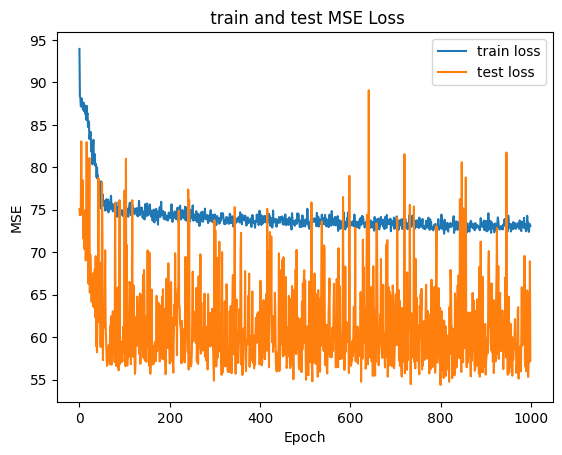

In [386]:
#create loss plot

plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(' train and test MSE Loss')
plt.legend()
#plt.savefig('2-conv1d_OneHot-Loss-2pool.png')


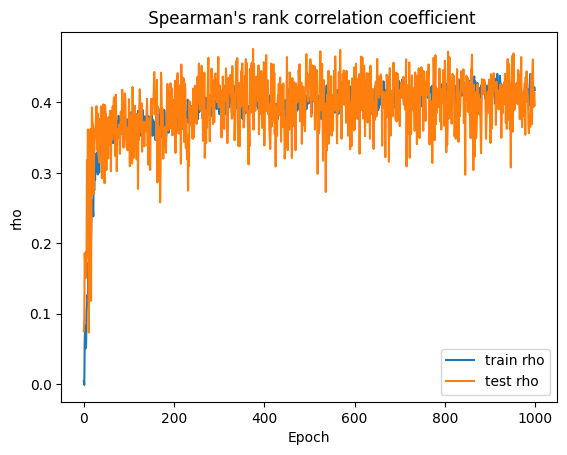

In [387]:
plt.plot(train_rho_history, label='train rho')
plt.plot(test_rho_history, label='test rho')
plt.xlabel('Epoch')
plt.ylabel('rho')
plt.title(' Spearman\'s rank correlation coefficient')
plt.legend()
#plt.savefig('2-conv1d_OneHot-rho-2pool.png')

In [388]:
torch.save(model.state_dict(), f"4-Test_Model_DeepSF.pth")

In [ ]:
test_df = pd.read_csv(path+ 'test.csv',index_col='seq_id')
test_df['tm']=submission_df['tm'].values
test_df = test_df.drop(columns=['protein_sequence','pH','data_source'])
test_df.to_csv('4-Test_Model_DeepSF.csv', index=True)